In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
import random
import os
import torch
import numpy as np

subplot_settings = dict(figsize=[7, 3], dpi=150, tight_layout=True)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return np.random.default_rng(seed)
rng = seed_torch()

/Users/phinate/code/flow-interpolation/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array(
            [[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]]
        ) @ jnp.array([[1/r,0],[0,1]])
    return T @ T.T

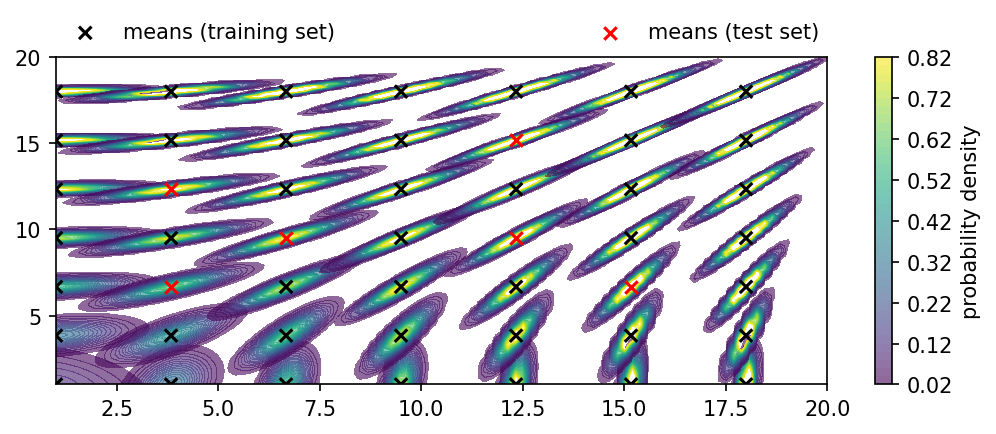

In [3]:

def xy_pairs(nx, ny, start, stop):
    size = nx, ny
    x_grid = jnp.linspace(start, stop, nx)
    y_grid = jnp.linspace(start, stop, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

val = 15
xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, 1, 20)
num_means = 7
means, g, xx2, yy2 = xy_pairs(num_means,num_means, 1, 18)

# covs = jnp.array([jnp.array([[1,0],[0,1]]) for _ in means])
covs = TT(means)
def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots(**subplot_settings)

step = 0.02
m = jnp.amax(pdfs[int(len(pdfs) / 2 - num_means/4)])
levels = jnp.arange(0.0, m, step) + step
for i,pdf in enumerate(pdfs):
    a = ax.contourf(xx, yy, pdf,  alpha=0.6, levels=levels)

inner_means = means.reshape(num_means, num_means, 2)[1:-1, 1:-1, :].reshape(-1, 2)
test_idxs = rng.choice(len(inner_means), size=int(len(inner_means)/4), replace=False)
test = inner_means[test_idxs].tolist()
test = [[15.166666984558105, 6.666666507720947],
 [6.666666507720947, 9.5],
 [12.333333015441895, 9.5],
 [12.333333015441895, 15.166666984558105],
 [3.8333332538604736, 6.666666507720947],
 [3.8333332538604736, 12.333333015441895]]

ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="means (training set)")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="means (test set)")

plt.colorbar(a, ax=ax, label="probability density")
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, frameon=False)
# ax.legend(loc="upper center", fancybox=True,);
plt.savefig('non-simple_data_dists.pdf', bbox_inches='tight')

In [4]:
test

[[15.166666984558105, 6.666666507720947],
 [6.666666507720947, 9.5],
 [12.333333015441895, 9.5],
 [12.333333015441895, 15.166666984558105],
 [3.8333332538604736, 6.666666507720947],
 [3.8333332538604736, 12.333333015441895]]

In [5]:
from jax.random import multivariate_normal, PRNGKey

train_mask = jnp.array([x not in test for x in means.tolist()])
train_context = means[train_mask]  # making this a variable for use later

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

train_samples = samples(train_context, covs[train_mask])
assert train_samples.shape[0] == len(means) - len(test)

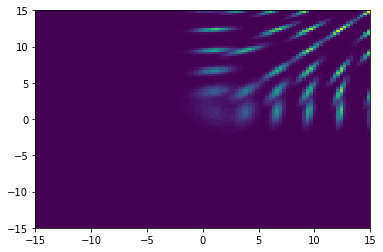

In [6]:
fig, ax = plt.subplots()

bins = np.linspace(-val, val, 100), np.linspace(-val, val, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-val,val))
    ax.set_ylim((-val,val))

plot(ax, jnp.concatenate(train_samples), 0)
# ax.scatter(xx2, yy2, marker='x', c='r', label ="distribution means")

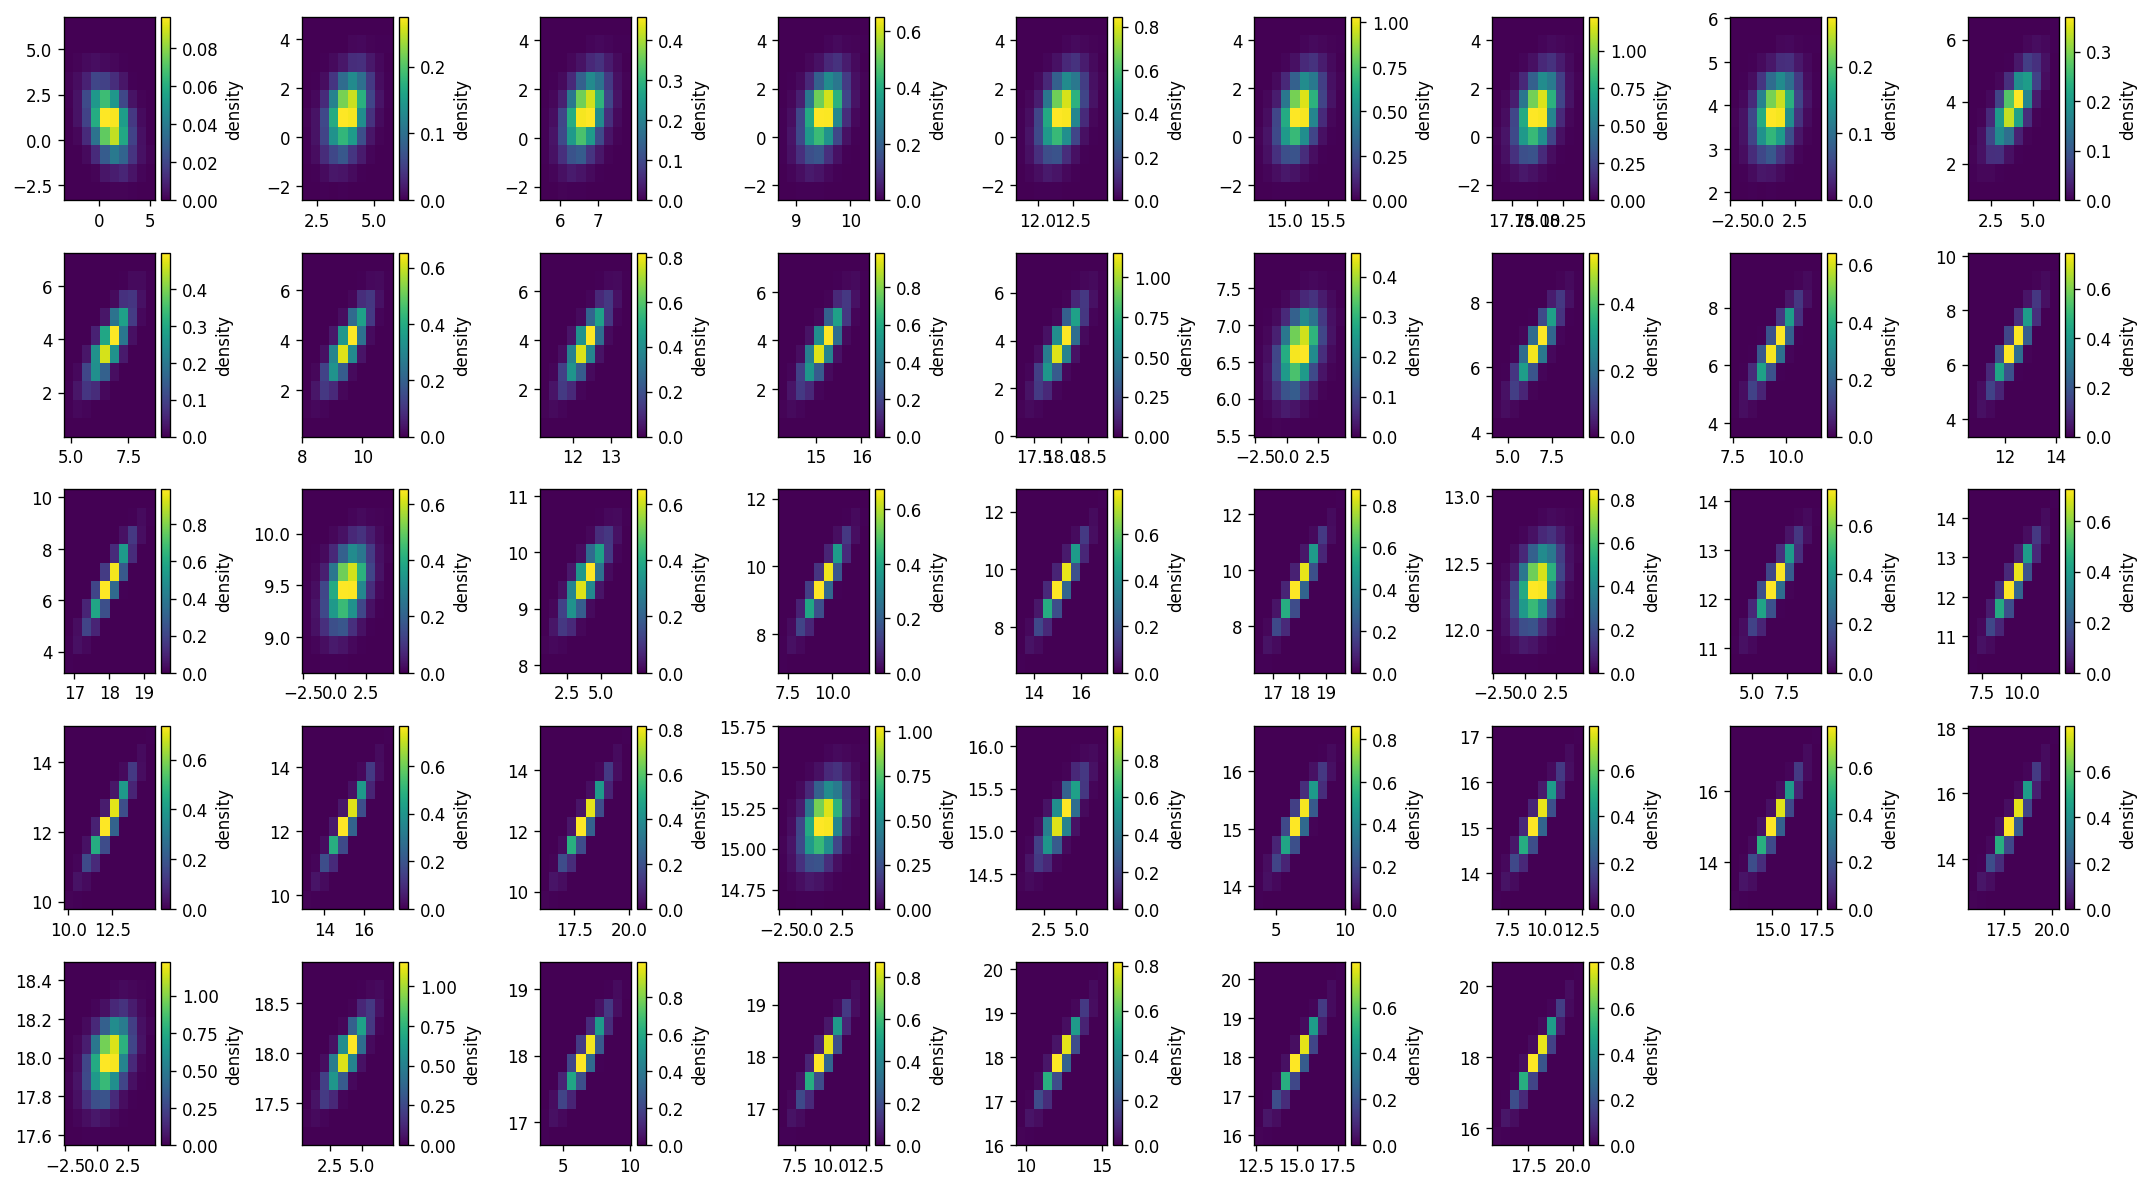

In [7]:
from plothelp import autogrid
from flow_interp import train, sample

train_data_hists, train_x_bins, train_y_bins = sample.make_data_hists2d(train_samples)

def hist_plot(dct):
    hist, *bins = dct["data"]
    ax = dct["ax"]
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='density')

autogrid(
    list(zip(train_data_hists, train_x_bins, train_y_bins)),
    hist_plot,
    
);

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

train_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in range(len(train_samples))])

train_concat = np.concatenate(train_samples)


train_and_valid = np.hstack((train_concat, train_context_array))
rng.shuffle(train_and_valid)

# do a second validation split that uses data from the context points in the training set
train_all, valid_from_train = train_test_split(train_and_valid, test_size=0.2)
feature_scaler = StandardScaler().fit(train_all[:,:2])
context_scaler = StandardScaler().fit(train_all[:,2:])

In [9]:
valid_from_train[:,2:]

array([[15.16666698,  1.        ],
       [ 6.66666651, 15.16666698],
       [ 6.66666651,  1.        ],
       ...,
       [ 1.        ,  3.83333325],
       [12.33333302, 18.        ],
       [18.        , 15.16666698]])

In [10]:
def batches(train, batch_size, rng):
    num_train = train.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism
    def data_stream():
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield train[batch_idx][:, :2], train[batch_idx][:, 2:]  # features, context

    return data_stream()

batch_iter = batches(train_all, 4000, rng)

In [11]:
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation




optimiser=optim.Adam
optimiser_pars=dict(lr=1e-3)

def make_flow(num_layers=10, hidden_features=6):
    base_dist = ConditionalDiagonalNormal(shape=[2], context_encoder=nn.Linear(2, 4))

    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=2))
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=2, hidden_features=hidden_features, context_features=2
            )
        )
    transform = CompositeTransform(transforms)

    return Flow(transform, base_dist)

flow = make_flow()
opt = optimiser(flow.parameters(), **optimiser_pars)

In [12]:
from flow_interp import sample
test_samples = samples(jnp.array(test), covs[~train_mask])
assert test_samples.shape[0] == len(test)
test_data_hists, test_x_bins, test_y_bins = sample.make_data_hists2d(test_samples, density=False)
test_mask = jnp.array([x in test for x in means.tolist()])
test_covs = covs[test_mask]

In [14]:
from flow_interp import train, sample
test_context_array = np.concatenate([[test[i]]*len(test_samples[i]) for i in range(len(test))])
valid_from_test = np.hstack((np.concatenate(test_samples), test_context_array))
valid = np.concatenate(
    (valid_from_train[:,:2], valid_from_test[:, :2])
    ), np.concatenate(
        (valid_from_train[:,2:], valid_from_test[:, 2:])
    )


for i in range(10):
    flow = make_flow()
    opt = optimiser(flow.parameters(), **optimiser_pars)
    result, metric, iteration, losses = train.train_loop(
        3000, 
        flow, 
        opt, 
        batch_iter, 
        valid_set = valid, 
        feature_scaler=feature_scaler, 
        context_scaler=context_scaler,
        print_every = 500
    )
    torch.save(result, f"flow{i}.pt")

iteration 0:
train loss = 10.261189460754395
valid loss = 9.329937934875488
iteration 499:
train loss = -2.460064172744751
valid loss = -1.3127076625823975
iteration 999:
train loss = -2.538130283355713
valid loss = -1.1380311250686646
iteration 1499:
train loss = -2.5992166996002197
valid loss = -1.0677289962768555
iteration 1999:
train loss = -2.585993766784668
valid loss = -1.0365303754806519
iteration 2499:
train loss = -2.563237190246582
valid loss = -1.0221563577651978
iteration 2999:
train loss = -2.569528341293335
valid loss = -0.9515475034713745
iteration 0:
train loss = 12.218515396118164
valid loss = 11.553592681884766
iteration 499:
train loss = -2.2348251342773438
valid loss = -1.0786893367767334
iteration 999:
train loss = -2.46758770942688
valid loss = -1.084395170211792
iteration 1499:
train loss = -2.52083420753479
valid loss = -0.9663938283920288
iteration 1999:
train loss = -2.5220425128936768
valid loss = -0.8562517166137695
iteration 2499:
train loss = -2.579901933

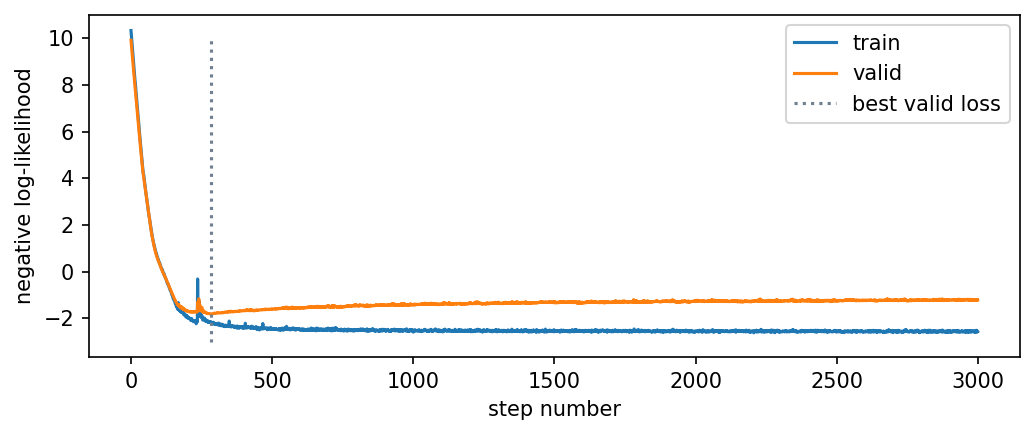

In [78]:
fig, ax = plt.subplots(**subplot_settings)
ax.plot(torch.tensor(losses[0]).detach(), label='train')
ax.plot(losses[1], label='valid')
ax.vlines(iteration, -3, np.max(losses[1]), label="best valid loss", linestyle="dotted", color="slategray")
ax.set_xlabel('step number')
ax.set_ylabel('negative log-likelihood')
ax.legend();
# plt.savefig('non-simple_example_loss.pdf', bbox_inches='tight')

/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_40188/2231470684.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  a = ax.contourf(xx, yy, fpdf,  alpha=0.6, cmap='plasma', levels=levels, norm=colors.LogNorm())


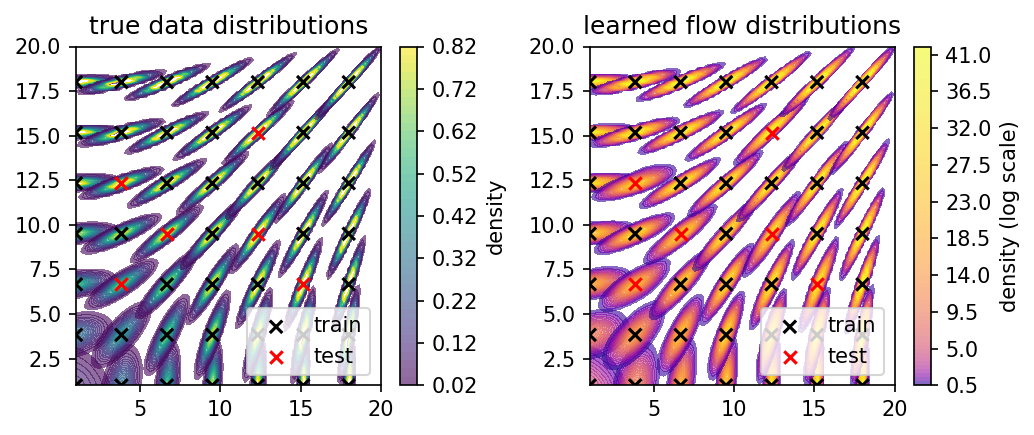

In [15]:
from matplotlib import colors
flows = [make_flow() for _ in range(10)]
for i,flow in enumerate(flows):
    flow.load_state_dict(torch.load(f"flow{i}.pt"))

fig, axs = plt.subplots(1,2, **subplot_settings)

ax = axs[0]
step = 0.02
m = jnp.amax(pdfs[int(len(pdfs) / 2 - num_means/4)])
levels = jnp.arange(0.0, m, step) + step
for i,pdf in enumerate(pdfs):
    a = ax.contourf(xx, yy, pdf,  alpha=0.6, cmap='viridis',levels=levels)
plt.colorbar(a, ax=ax, label="density")
ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="train")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="test")
ax.set_title("true data distributions")
ax.legend(loc="lower right", fancybox=True,);

def flow_pdf(inputs, context):
    transformed_inputs = torch.tensor(feature_scaler.transform(inputs), dtype=torch.float32)
    if context is not None:
        transformed_context = torch.tensor(context_scaler.transform(context), dtype=torch.float32)
    else:
        transformed_context = None
    pdfs = [np.asarray(flow.log_prob(transformed_inputs, transformed_context).exp().detach()) for flow in flows]
    return pdfs

with torch.no_grad():
    flow_pdfs = [np.array(flow_pdf(xy_pairs_eval.tolist(), [context]*len(xy_pairs_eval))).mean(axis=0) for context in means.tolist()] 
flow_pdfs = np.asarray(flow_pdfs).reshape(len(means), *grid_size)
ax = axs[1]
step = 0.5
m = jnp.amax(flow_pdfs[int(len(flow_pdfs) - num_means)])
levels = jnp.arange(0.0, m, step) + 0.5
# levels = jnp.concatenate([jnp.arange(0.0, m, step) + step,jnp.array([100])])
for i,fpdf in enumerate(flow_pdfs):
    a = ax.contourf(xx, yy, fpdf,  alpha=0.6, cmap='plasma', levels=levels, norm=colors.LogNorm())
plt.colorbar(a, ax=ax, label="density (log scale)")
ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="train")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="test")
ax.set_title("learned flow distributions")
plt.tight_layout()
ax.legend(loc="lower right", fancybox=True,)
plt.savefig('non-simpleflowvsdata.pdf', bbox_inches='tight')

In [16]:
bins = test_x_bins[0], test_y_bins[0]
from matplotlib import colors
err = (dh-fh)
divnorm=colors.TwoSlopeNorm(vmin=np.min(err), vcenter=0., vmax=np.max(err))
XX, YY = np.meshgrid(bins[0], bins[1])
fig, axs = plt.subplots(1,2,**subplot_settings)
ax = axs[0]
a = ax.pcolormesh(XX, YY, (dh.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(a, ax=ax, label='density')
ax = axs[1]
a = ax.pcolormesh(XX, YY, ((fh-dh).T), shading='flat',cmap='seismic', norm=divnorm)#, norm=colors.LogNorm())
plt.colorbar(a, ax=ax, label='density')
print(np.sum(dh), np.sum(fh))

NameError: name 'dh' is not defined

In [17]:
bins, bins

((array([11.99965   , 12.63598871, 13.27232742, 13.90866613, 14.54500484,
         15.18134356, 15.81768227, 16.45402098, 17.09035969, 17.7266984 ,
         18.36303711]),
  array([4.49138498, 4.9223454 , 5.35330582, 5.78426623, 6.21522665,
         6.64618707, 7.07714748, 7.5081079 , 7.93906832, 8.37002873,
         8.80098915])),
 (array([11.99965   , 12.63598871, 13.27232742, 13.90866613, 14.54500484,
         15.18134356, 15.81768227, 16.45402098, 17.09035969, 17.7266984 ,
         18.36303711]),
  array([4.49138498, 4.9223454 , 5.35330582, 5.78426623, 6.21522665,
         6.64618707, 7.07714748, 7.5081079 , 7.93906832, 8.37002873,
         8.80098915])))

In [18]:

# bins = [np.linspace(0,25,30) for _ in test]
from plothelp import autogrid

test_data_hists, test_x_bins, test_y_bins = sample.make_data_hists2d(test_samples, density=False)#, bins=np.vstack([bins,bins]))
flow_hists, errs = sample.hist2d_from_flows_with_error(flows, test_x_bins, test_y_bins, feature_scaler, context_scaler=context_scaler, context=test, num_samples=100000, density=False, normalized_counts=10000)#, return_bins=True)



train_data_hists, train_x_bins, train_y_bins = sample.make_data_hists2d(train_samples, density=False)#, bins=np.vstack([bins,bins]))
flow_hists_train, errs_train = sample.hist2d_from_flows_with_error(flows, train_x_bins, train_y_bins, feature_scaler, context_scaler=context_scaler, context=train_context, num_samples=100000, density=False, normalized_counts=10000)#, return_bins=True)
from scipy.stats import chisquare

# dh = test_data_hists[0]
# fh = flow_hists[0]
# # cond = (dh>0) * (fh > 0)
# cond = dh < 99999
# chisquare(dh[cond], fh[cond])


/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_50325/3334951098.py:8: RuntimeWarning: divide by zero encountered in divide
  err = abs(dh-fh)/dh
/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_50325/3334951098.py:8: RuntimeWarning: invalid value encountered in divide
  err = abs(dh-fh)/dh


(0.2711046086320409, 204.9)
(0.2684210526315789, 225.9)
(0.09999999999999987, 206.15)
(0.022390841320553877, 90.25)
(0.034249628528974674, 173.97500000000002)
(0.058333333333333424, 372.95000000000005)


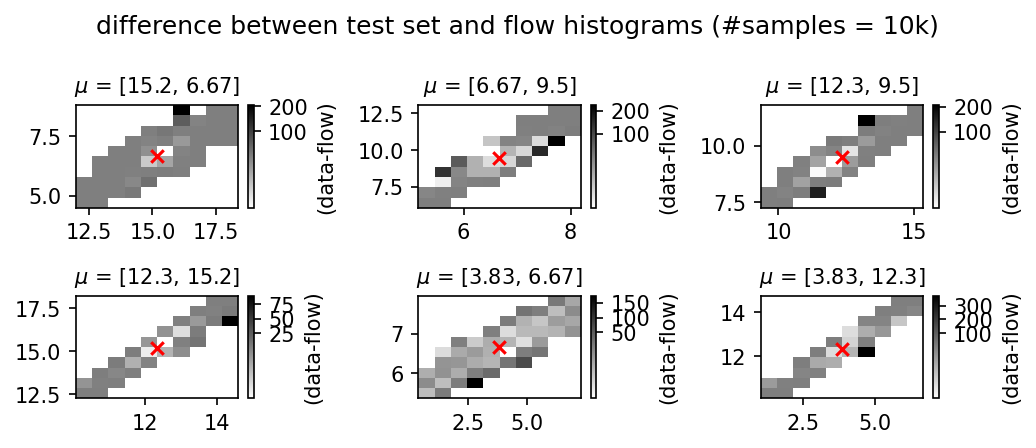

In [77]:

min_level, max_level = -100, 100
def hist_plot_flow(dct):
    fh, dh, *bins, test, e= dct["data"]
    ax = dct["ax"]
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    # pdf = gaussian_2d_pdf(pairs, jnp.array(test[i]), test_covs[i]).reshape(XX.shape)
    err = abs(dh-fh)/dh
    finite = err[np.isfinite(err)]
    # err[~np.isfinite(err)] = 0
    lvls = min_level, max_level = np.nanmin(finite), np.nanmax(finite)
    print(lvls)
    norm=colors.TwoSlopeNorm(vmin=min_level, vcenter=1., vmax=max_level)
    # norm = colors.LogNorm(*lvls)
    a = ax.pcolormesh(XX, YY, (err.T), cmap="binary", norm=norm)
    # ax.contourf(XX, YY, pdf, levels=levels, alpha=0.4, cmap='cool')
    plt.colorbar(a, ax=ax, label='(data-flow)')
    ax.set_title(f"$\mu$ = [{test[0]:.3g}, {test[1]:.3g}]", size="medium")
    ax.scatter(*test, marker='x', c='red', label="$\mu$")
    # ax.legend(loc="upper left", fontsize="tiny")
    # ax.axis("off")

    

autogrid(
    list(zip(flow_hists, test_data_hists, test_x_bins, test_y_bins, test, errs)),
    hist_plot_flow,
    subplot_kwargs=subplot_settings,
    title="difference between test set and flow histograms (#samples = 10k)"
);
# plt.savefig('non-simplehistdifftest-errors.pdf', bbox_inches='tight')

(-306.5, 65.14999999999999)
(-54.80000000000001, 127.0)
(-32.5, 57.0)
(-51.10000000000002, 82.04999999999995)
(-56.10000000000002, 72.79999999999995)
(-41.0, 63.89999999999998)
(-47.400000000000006, 58.0)
(-60.19999999999999, 103.84999999999997)
(-87.45000000000005, 141.29999999999995)
(-59.80000000000001, 70.70000000000005)
(-64.80000000000018, 50.84999999999991)
(-39.65000000000009, 50.64999999999998)
(-86.10000000000002, 120.29999999999995)
(-93.0, 74.89999999999998)
(-63.39999999999998, 85.64999999999998)
(-108.90000000000009, 70.69999999999993)
(-75.34999999999991, 97.84999999999991)
(-69.65000000000009, 88.34999999999991)
(-91.90000000000009, 58.34999999999991)
(-73.40000000000009, 90.39999999999998)
(-85.04999999999995, 73.0)
(-88.80000000000018, 112.89999999999998)
(-74.20000000000005, 106.09999999999991)
(-60.200000000000045, 62.049999999999955)
(-33.349999999999994, 75.39999999999998)
(-52.950000000000045, 72.14999999999986)
(-61.85000000000002, 100.59999999999991)
(-42.0, 72

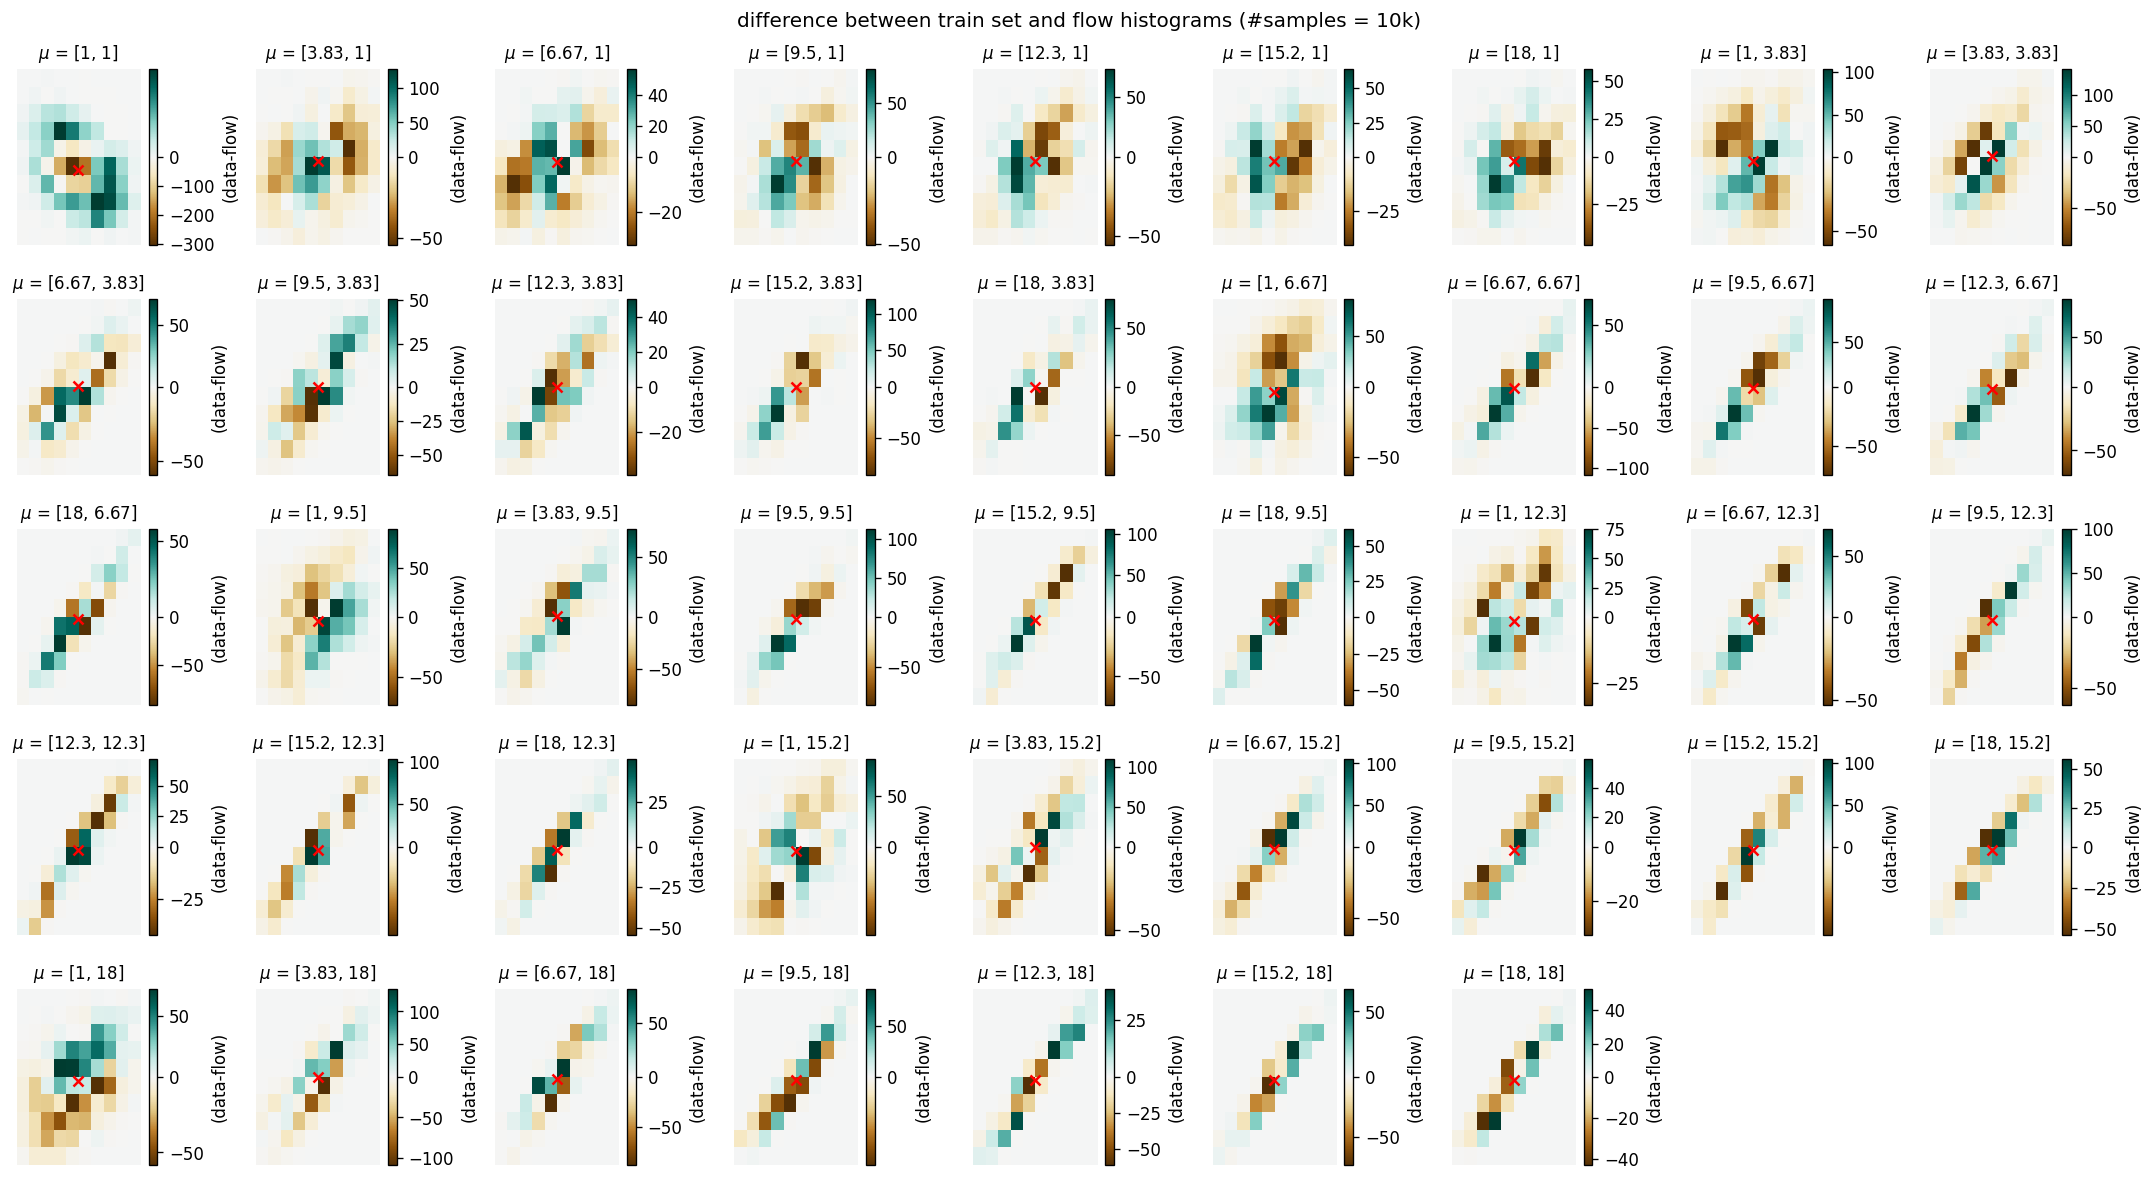

In [27]:




autogrid(
    list(zip(flow_hists_train, train_data_hists, train_x_bins, train_y_bins, train_context, errs_train)),
    hist_plot_flow,
    title="difference between train set and flow histograms (#samples = 10k)"
);

plt.savefig('non-simplehistdifftrain-reallyunscaled.pdf', bbox_inches='tight')

/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_40188/270876773.py:8: RuntimeWarning: divide by zero encountered in divide
  err = ((np.array(dh)-np.array(fh))/e)
/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_40188/270876773.py:8: RuntimeWarning: invalid value encountered in divide
  err = ((np.array(dh)-np.array(fh))/e)


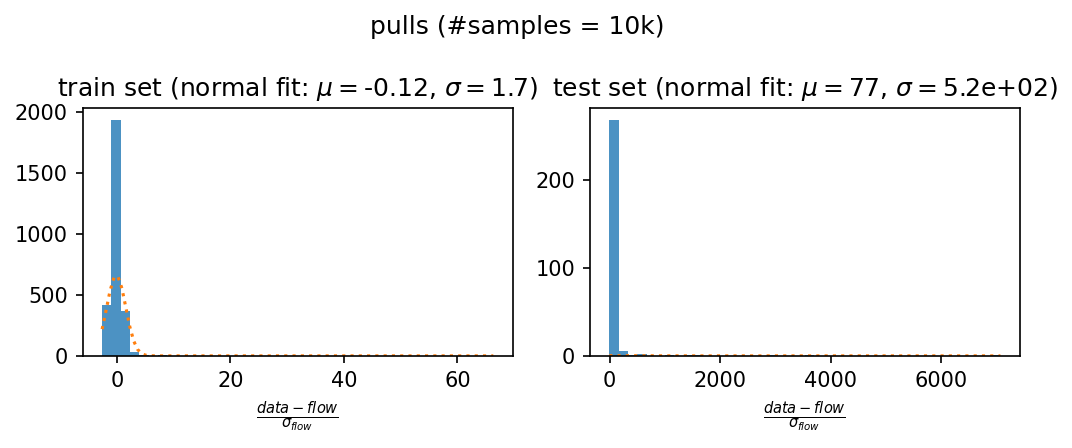

In [19]:

from scipy import stats
def pull_plot(dct):
    fh, dh, *bins, test, e= dct["data"]
    ax = dct["ax"]
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    # pdf = gaussian_2d_pdf(pairs, jnp.array(test[i]), test_covs[i]).reshape(XX.shape)
    err = ((np.array(dh)-np.array(fh))/e)
    mu, sigma = stats.norm.fit(err[np.isfinite(err)])
    grid = np.linspace(np.min(err[np.isfinite(err)]), np.max(err[np.isfinite(err)]), 100) 
    ax.hist(err[np.isfinite(err)],bins=42, label="data histogram", alpha=0.8)
    ax.set_xlabel(r"$\frac{data-flow}{\sigma_{flow}}$")
    nd = stats.norm.pdf(grid, mu, sigma) 
    ax.plot(grid, nd*len(err[np.isfinite(err)]), linestyle="dotted",label="fitted normal dist.")
    if dct["i"] ==0:
        ax.set_title("train set (normal fit: "+r'$\mu=$'+f'{mu:.2g}, '+r'$\sigma=$'+f'{sigma:.2g})')
    else:
        ax.set_title('test set (normal fit: '+r'$\mu=$'+f'{mu:.2g}, '+r'$\sigma=$'+f'{sigma:.2g})')
    # ax.set_title(f"$\mu$ = [{test[0]:.3g}, {test[1]:.3g}]", size="medium")
    # ax.legend(loc="upper left", fontsize="tiny")
    # ax.axis("off")

autogrid(
    [[flow_hists_train, train_data_hists, train_x_bins, train_y_bins, train_context, errs_train], [flow_hists, test_data_hists, test_x_bins, test_y_bins, test, errs]],
    pull_plot,
    subplot_kwargs=subplot_settings,
    title="pulls (#samples = 10k)"
);
plt.savefig('non-simpleflowpulls.pdf', bbox_inches='tight')

/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_50325/3568736549.py:8: RuntimeWarning: divide by zero encountered in divide
  err = ((np.array(dh)-np.array(fh))/e)
/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_50325/3568736549.py:8: RuntimeWarning: invalid value encountered in divide
  err = ((np.array(dh)-np.array(fh))/e)


0.9543307086614173
0.7854406130268199


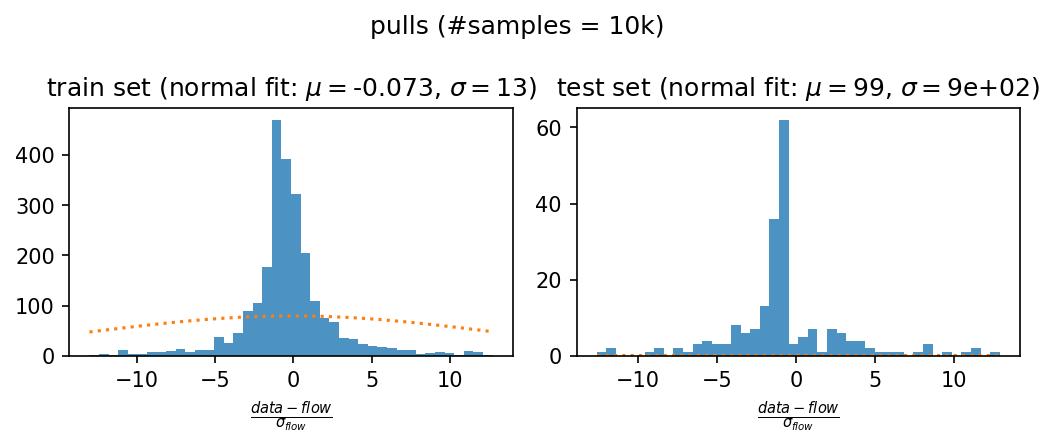

In [49]:

from scipy import stats
def pull_plot(dct):
    fh, dh, *bins, test, e= dct["data"]
    ax = dct["ax"]
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    # pdf = gaussian_2d_pdf(pairs, jnp.array(test[i]), test_covs[i]).reshape(XX.shape)
    err = ((np.array(dh)-np.array(fh))/e)
    mu, sigma = stats.norm.fit(err[np.isfinite(err)])
    
    finite = err[np.isfinite(err)]
    filtered = finite[(-13 < finite) * (finite < 13)]
    print(len(filtered)/len(finite))
    ax.hist(filtered,bins=42, label="data histogram", alpha=0.8)
    ax.set_xlabel(r"$\frac{data-flow}{\sigma_{flow}}$")
    grid = np.linspace(np.min(filtered), np.max(filtered), 100) 
    nd = stats.norm.pdf(grid, mu, sigma) 
    ax.plot(grid, nd*len(err[np.isfinite(err)]), linestyle="dotted",label="fitted normal dist.")
    if dct["i"] ==0:
        ax.set_title("train set (normal fit: "+r'$\mu=$'+f'{mu:.2g}, '+r'$\sigma=$'+f'{sigma:.2g})')
    else:
        ax.set_title('test set (normal fit: '+r'$\mu=$'+f'{mu:.2g}, '+r'$\sigma=$'+f'{sigma:.2g})')
    # ax.set_title(f"$\mu$ = [{test[0]:.3g}, {test[1]:.3g}]", size="medium")
    # ax.legend(loc="upper left", fontsize="tiny")
    # ax.axis("off")

autogrid(
    [[flow_hists_train, train_data_hists, train_x_bins, train_y_bins, train_context, errs_train], [flow_hists, test_data_hists, test_x_bins, test_y_bins, test, errs]],
    pull_plot,
    subplot_kwargs=subplot_settings,
    title="pulls (#samples = 10k)"
);
plt.savefig('filtered-non-simpleflowpulls.pdf', bbox_inches='tight')

In [ ]:
flow.load_state_dict(result)
flow_hists, _ = sample.hist2d_from_flows_with_error([flow], train_x_bins, train_y_bins, feature_scaler, context_scaler=context_scaler, context=train_context, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    pdf = gaussian_2d_pdf(pairs, jnp.array(train_context[i]), covs[train_mask][i]).reshape(XX.shape)
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='binary')#, norm=colors.LogNorm())
    ax.contourf(XX, YY, pdf, levels=levels, alpha=0.2, cmap='cool')
    plt.colorbar(a, ax=ax, label='flow histogram')
    

autogrid(
    list(zip(flow_hists, train_x_bins, train_y_bins)),
    hist_plot_flow,
);

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

lrs = [1e-2, 5e-2, 1e-3]
valid_errors = {}

for lr in lrs:
    valid_error = 0
    for i,(train_idxs, valid_idxs) in enumerate(kf.split(train_context.tolist())):
        print(f'fold {i+1}')
        train_points = train_context[train_idxs].tolist()
        valid_points = train_context[valid_idxs].tolist()
        train_fold, valid_fold = np.concatenate(train_samples[train_idxs]), np.concatenate(train_samples[valid_idxs])
        train_fold_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in train_idxs])
        assert train_fold.shape == train_fold_context_array.shape
        train_fold_all = np.hstack((train_fold, train_fold_context_array))
        fold_batch_iter = batches(train_fold_all, batch_size=4000, rng=rng)
        flow = make_flow()
        opt = optimiser(flow.parameters(), lr=lr)    
        _ = train.train_loop(6000, flow, opt, fold_batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)
        valid_hists, valid_x_bins, valid_y_bins = sample.make_data_hists2d(train_samples[valid_idxs])
        flow_valid_hists, _ = sample.hist2d_from_flows_with_error([flow], valid_x_bins, valid_y_bins, feature_scaler, context_scaler=context_scaler, context=valid_points, num_samples=10000, density=True)
        metric = np.sum((valid_hists-flow_valid_hists)**2)
        valid_error += metric
    valid_errors[str(lr)] = valid_error


In [ ]:
lr = 1e-2  # best lr from previous step
num_iters = [5500, 6000, 6500, 7000]
valid_errors = {}

for num_iter in num_iters:
    valid_error = 0
    for i,(train_idxs, valid_idxs) in enumerate(kf.split(train_context.tolist())):
        print(f'fold {i+1}')
        train_points = train_context[train_idxs].tolist()
        valid_points = train_context[valid_idxs].tolist()
        train_fold, valid_fold = np.concatenate(train_samples[train_idxs]), np.concatenate(train_samples[valid_idxs])
        train_fold_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in train_idxs])
        assert train_fold.shape == train_fold_context_array.shape
        train_fold_all = np.hstack((train_fold, train_fold_context_array))
        fold_batch_iter = batches(train_fold_all, batch_size=4000, rng=rng)
        flow = make_flow()
        opt = optimiser(flow.parameters(), lr=lr)    
        _ = train.train_loop(num_iter, flow, opt, fold_batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)
        valid_hists, valid_x_bins, valid_y_bins = sample.make_data_hists2d(train_samples[valid_idxs])
        flow_valid_hists, _ = sample.hist2d_from_flows_with_error([flow], valid_x_bins, valid_y_bins, feature_scaler, context_scaler=context_scaler, context=valid_points, num_samples=10000, density=True)
        metric = np.sum((valid_hists-flow_valid_hists)**2)
        valid_error += metric
    valid_errors[str(num_iter)] = valid_error

In [ ]:
valid_error_res = {'5500': 41.45121081982253,
 '6000': 42.40899898187116,
 '6500': 40.91227636062254,
 '7000': 44.72141666924373}

num_iter = 6500

In [ ]:
flow = make_flow()
opt = optimiser(flow.parameters(), lr=1e-2)
train.train_loop(num_iter, flow, opt, batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)

In [ ]:
from matplotlib import colors
test_pdfs = pdfs[test_mask]
flow_hists, _ = sample.hist2d_from_flows_with_error([flow], test_x_bins, test_y_bins, feature_scaler, context_scaler=context_scaler, context=test, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    print(np.nanmin(hist), np.nanmax(hist))
    a = ax.pcolormesh(XX, YY, (hist.T),norm=colors.LogNorm(vmin=np.nanmin(hist)+1e-9, vmax=np.nanmax(np.where(hist==np.inf, 0, hist))),
                   cmap='Reds', shading='auto')
    ax.contour(XX, YY, test_pdfs[i], levels=levels, alpha=0.8)
    plt.colorbar(a, ax=ax, label='absolute relative error')

def hist_plot(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='density')
    ax.scatter(test[i][0], test[i][1])
autogrid(
    list(zip(flow_hists, test_x_bins, test_y_bins)),
    hist_plot,
);